# INTELIGENCIA ARTIFICIAL EXPLICATIVA (XAI)

In [1]:
#---- LIBRERIAS PARA LOS DATOS ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#---- LIBRERIAS PARA ML ----
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

#---- LIBRERIAS PARA XAI ----
from lime.lime_tabular import LimeTabularExplainer

#---- LIBRERIAS EXTRAS ----
import os

In [2]:
from ipywidgets import interact, widgets

In [3]:
USER = os.environ["USERNAME"]
directorio_output = F"C:\\Users\\dxcor\\Desktop\\AnteProyecto CI-2025.2026\\Natanael\\licitaciones\\data\\output\\dataEDA"
archivos = [archivo for archivo in os.listdir(directorio_output) if archivo.endswith(".parquet")]

In [4]:
directorio_output

'C:\\Users\\dxcor\\Desktop\\AnteProyecto CI-2025.2026\\Natanael\\licitaciones\\data\\output\\dataEDA'

In [5]:
df = pd.read_parquet(f"{directorio_output}\\{archivos[0]}",engine="pyarrow")

## Funciones

In [6]:
def visualizarImportanciaPredictores(modelo,nombre_modelo:str, experimento:str):
    importancia_predictores = pd.DataFrame({'predictor': df[used_features].columns,'importancia': modelo.feature_importances_})

    # Mostrar la importancia de los predictores ordenada
    print(f"Importancia de los predictores en el modelo {nombre_modelo} - Experimento {experimento}")
    print("-------------------------------------------")
    print(importancia_predictores.sort_values('importancia', ascending=False))

In [7]:
def generarGraficoMatrizConfusion(matriz,clases):
    # Configurar el tamaño del gráfico
    plt.figure(figsize=(25, 13))

    # Crear la matriz de confusión con seaborn
    sns.heatmap(matriz, annot=True, cmap='Blues', fmt='g', xticklabels=clases, yticklabels=clases, 
                linewidths=.5,square=True,annot_kws={"size": 10}, linecolor="blue")

    # Configurar etiquetas y título
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [8]:
def generarComparativaModelos(prediccion_random_forest, prediccion_gradient_boosting, y_test):
    models = {
    'Random Forest': prediccion_random_forest,
    'Gradient Boosting': prediccion_gradient_boosting
    }

    metrics = ['accuracy', 'precision', 'recall', 'f1']

    # Crear un diccionario para almacenar los resultados
    results = {}

    for model_name, y_pred in models.items():
        results[model_name] = {
            'accuracy': accuracy_score(y_test.values, y_pred),
            'precision': precision_score(y_test.values, y_pred, average='macro'),
            'recall': recall_score(y_test.values, y_pred, average='macro'),
            'f1': f1_score(y_test.values, y_pred, average='macro')
        }

    # Imprimir los resultados de manera más compacta
    print("METRICAS               ACCURACY  PRECISION  RECALL  F1")
    for model_name, metrics_dict in results.items():
        print(f"{model_name:<20} -> {metrics_dict['accuracy']:.4f}    {metrics_dict['precision']:.4f}   {metrics_dict['recall']:.4f}   {metrics_dict['f1']:.4f}")

In [9]:
def generarGraficosExplicativos(df: pd.DataFrame, clases, modelo, prediccion):
    explainer = LimeTabularExplainer(training_data=df.values,
                                    feature_names= df.columns,
                                    class_names=clases,
                                    mode='classification')
    
    for i in range(len(df.values)):
        exp = explainer.explain_instance(
            df.values[i],
            predict_fn=modelo.predict_proba,
            num_features=len(df.columns)
        )

        # Obtener las etiquetas disponibles
        available_labels = exp.available_labels()
        
        # Obtener reglas para todas las clases disponibles
        for class_name in available_labels:
            print(f"Reglas para la clase {class_name}:")
            rules = convert_to_if_then(exp, class_name, prediccion[i])
            for rule in rules:
                print(f"  {rule}")
        
        # Mostrar las explicaciones en el notebook (opcional)
        exp.show_in_notebook(show_table=True, show_all=False)

In [10]:
def calculate_class_metrics(confusion_matrix, class_names):
    num_classes = confusion_matrix.shape[0]
    metrics = {}

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fn = np.sum(confusion_matrix[i, :]) - tp
        fp = np.sum(confusion_matrix[:, i]) - tp
        tn = np.sum(confusion_matrix) - (tp + fp + fn)

        metrics[class_names[i]] = {
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn
        }
    
    return metrics

In [11]:
def generarGraficoMetricas(clase_name, metrics):
    def update_plot(clase_name):
        # Obtener los valores para la clase seleccionada
        valores = metrics[clase_name]
        
        categories = ['TP', 'TN', 'FP', 'FN']
        values = [valores['TP'], valores['TN'], valores['FP'], valores['FN']]
        
        # Crear el gráfico
        plt.figure(figsize=(8, 4))
        bars = plt.bar(categories, values, color=['blue', 'green', 'red', 'orange'])
        #plt.title(f'Métricas para {clase_name}')
        plt.ylabel('Número de Instancias')
        plt.xlabel(f"Metricas para {clase_name}")
        plt.ylim(0, max(values) + 10)  # Ajustar el límite superior del eje y para mejor visualización
        
        # Añadir etiquetas sobre cada barra
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, int(yval), ha='center', va='bottom')
    
        plt.show()

    # Crear un widget Dropdown para seleccionar la clase
    dropdown = widgets.Dropdown(
        options=clase_name,
        value=clase_name[0],  # Valor inicial
        description='Clase:',
        disabled=False
    )

    # Crear la interfaz interactiva
    interact(update_plot, clase_name=dropdown)

## Selección de N mejores caracteristicas según la correlación

In [12]:
used_features: list[str] = [
    "B_MULTIPLE_CAE_n", "B_ON_BEHALF_n",

    "GROUP_CPV_45","GROUP_CPV_33","GROUP_CPV_15",
    "TYPE_OF_CONTRACT_w","MAIN_ACTIVITY_health", "ISO_COUNTRY_CODE_si",

    "NUMBER_AWARDS", "LOTS_NUMBER", 
    "NUMBER_OFFERS", "NUMBER_TENDERS_SME",
    
    "CAE_TYPE_3", "MAIN_ACTIVITY_general public\services",
    "CAE_TYPE_4",
    "CAE_TYPE_5", "ISO_COUNTRY_CODE_lu"
]

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\dxcor\AppData\Local\Temp\ipykernel_5332\3504339641.py:10: SyntaxWarning: invalid escape sequence '\s'
  "CAE_TYPE_3", "MAIN_ACTIVITY_general public\services",


## Variables

In [13]:
etiquetas_a_clasificar = df[[c for c in df.columns if c not in used_features]].drop(columns=
    ["CAE_NAME", "CAE_TOWN", "DURATION", "VALUE_EURO", "CPV", 'CRIT_CRITERIA', 
    'CRIT_WEIGHTS', 'CRIT_PRICE_WEIGHT']
    ).columns

In [156]:
etiquetas_a_clasificar

Index(['WIN_COUNTRY_CODE', 'B_CONTRACTOR_SME', 'GROUP_CPV', 'GROUP_VALUE_EURO',
       'GROUP_DURATION', 'YEAR', 'CAE_TYPE', 'B_MULTIPLE_CAE', 'CAE_GPA_ANNEX',
       'B_ON_BEHALF', 'ID_TYPE', 'ISO_COUNTRY_CODE', 'TOP_TYPE',
       'TYPE_OF_CONTRACT', 'B_SUBCONTRACTED', 'MAIN_ACTIVITY'],
      dtype='object')

## Datos de entrenamiento y de prueba

In [141]:
X: pd.DataFrame = df.drop(columns=["MAIN_ACTIVITY", "GROUP_DURATION"], axis=1)        # Caracteristicas 
Y_GA = df["MAIN_ACTIVITY"]   
Y_GB = df["GROUP_DURATION"]                                          # Objetivo

In [142]:
# Dividir el DataFrame en conjuntos de entrenamiento y prueba (70-15-15)
# Donde 70% para entrenamiento - 15% para prueba - 15% para evaluación.

In [143]:
X_train_GA, X_temp_GA, y_train_GA, y_temp_GA = train_test_split(X, Y_GA, test_size=0.3, random_state=42)  # 30% para prueba-validación
X_test_GA, X_vali_GA, y_test_GA, y_vali_GA = train_test_split(X_temp_GA, y_temp_GA, test_size=0.5, random_state=42)  # 50% de 30% para prueba (15%) y valiuación (15%)

In [144]:
X_train_GB, X_temp_GB, y_train_GB, y_temp_GB = train_test_split(X, Y_GB, test_size=0.3, random_state=42)  # 30% para prueba-validación
X_test_GB, X_vali_GB, y_test_GB, y_vali_GB = train_test_split(X_temp_GB, y_temp_GB, test_size=0.5, random_state=42)  # 50% de 30% para prueba (15%) y evaluación (15%)

In [145]:
classes_GA = y_test_GA.sort_values().unique()
classes_GB = y_test_GB.sort_values().unique()

In [146]:
del X, Y_GA, Y_GB

## Modelos

### Validación Cruzada

In [21]:
random_forest_model = RandomForestClassifier(
    bootstrap=True,
    n_jobs=-1,
    max_samples=2/3,
    random_state=42, 
    n_estimators=100,
    warm_start=False)

In [22]:
parametros_a_explorar = {
    "criterion": ["gini", "entropy"], 
    "max_features": ["sqrt","log2"]}

In [23]:
parametros_a_explorar_GB = {"max_features": ['sqrt', 'log2']}

### EXPERIMENTO A

In [24]:
X_combined = np.vstack((X_train_GA[used_features], X_vali_GA[used_features]))
y_combined = np.concatenate((y_train_GA, y_vali_GA))

In [25]:
test_fold = np.full(X_combined.shape[0], -1)  # Inicialmente, todas las muestras están en el conjunto de entrenamiento
test_fold[len(X_train_GA[used_features]):(len(X_train_GA[used_features]) + len(X_vali_GA[used_features]))] = 0  # Las muestras del conjunto de prueba están en el conjunto de validación

In [26]:
ps = PredefinedSplit(test_fold=test_fold)

In [27]:
rejilla_GA = RandomizedSearchCV(estimator=random_forest_model, 
                      param_distributions=parametros_a_explorar, 
                      scoring='accuracy',
                      n_jobs=-1, 
                      random_state=42,
                      cv=ps)
rejilla_GA.fit(X_combined, y_combined)

c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=RandomForestClassifier(max_samples=0.6666666666666666,
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': ['sqrt', 'log2']},
                   random_state=42, scoring='accuracy')

In [28]:
print(f"El mejor accuracy es de {rejilla_GA.best_score_} lo tienen los HiperParametros {rejilla_GA.best_params_}")

El mejor accuracy es de 0.8345823037766166 lo tienen los HiperParametros {'max_features': 'sqrt', 'criterion': 'gini'}


#### Entrenamiento

In [29]:
random_forest_model_GA = rejilla_GA.best_estimator_

In [30]:
gb_model_GA = GradientBoostingClassifier(
    learning_rate=0.1,     
    init=random_forest_model_GA        # Establecer el random_forest_model pre-entrenado como el estimador base
)

#### Random Forest

In [31]:
y_rf_pred_GA = random_forest_model_GA.predict(X_test_GA[used_features])

c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


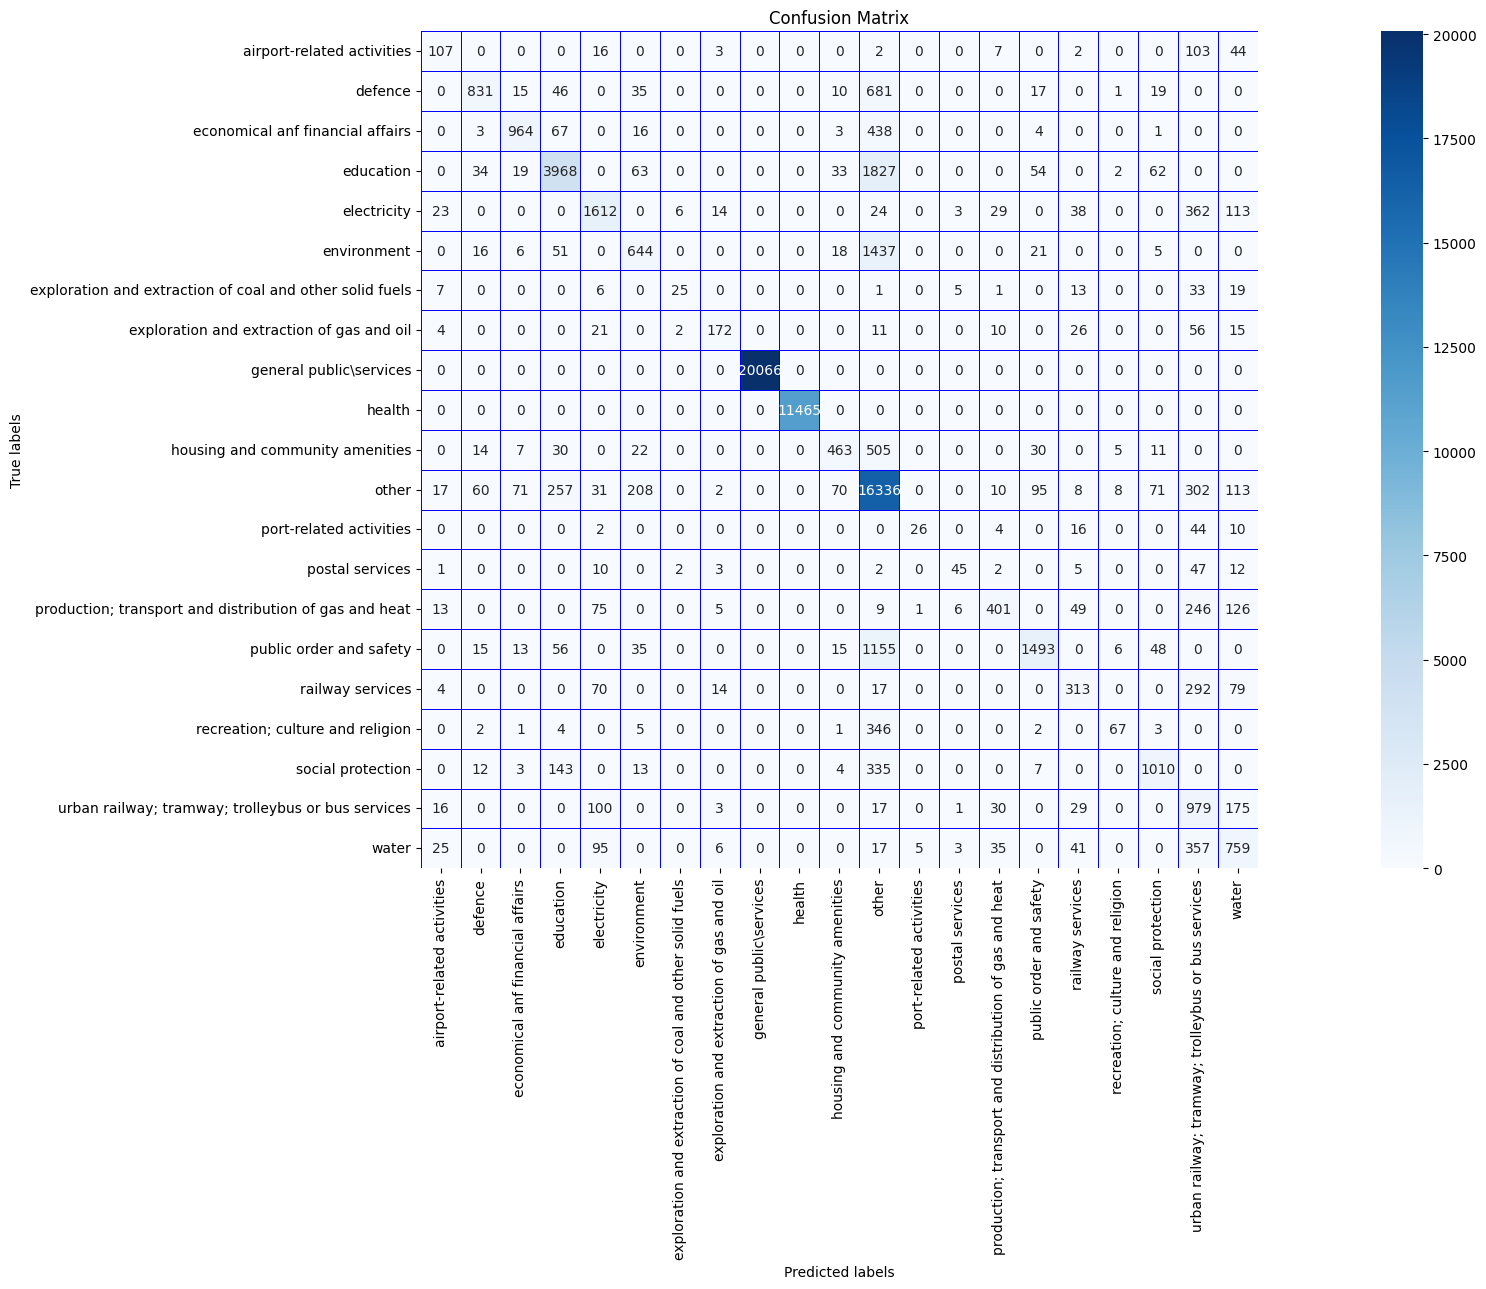

In [32]:
cnf_matrix_RF_GA=confusion_matrix(y_test_GA, y_rf_pred_GA)
generarGraficoMatrizConfusion(cnf_matrix_RF_GA, classes_GA)

In [33]:
metrics = calculate_class_metrics(cnf_matrix_RF_GA, classes_GA)
generarGraficoMetricas(classes_GA, metrics)

interactive(children=(Dropdown(description='Clase:', options=('airport-related activities', 'defence', 'econom…

In [34]:
visualizarImportanciaPredictores(random_forest_model_GA, "RANDOM FOREST", "A")

Importancia de los predictores en el modelo RANDOM FOREST - Experimento A
-------------------------------------------
                                predictor  importancia
13  MAIN_ACTIVITY_general public\services     0.321547
6                    MAIN_ACTIVITY_health     0.163550
8                           NUMBER_AWARDS     0.096012
9                             LOTS_NUMBER     0.086634
3                            GROUP_CPV_33     0.070151
10                          NUMBER_OFFERS     0.058054
14                             CAE_TYPE_4     0.052990
11                     NUMBER_TENDERS_SME     0.048584
12                             CAE_TYPE_3     0.033222
15                             CAE_TYPE_5     0.014599
4                            GROUP_CPV_15     0.014559
1                           B_ON_BEHALF_n     0.009952
7                     ISO_COUNTRY_CODE_si     0.009129
16                    ISO_COUNTRY_CODE_lu     0.007542
0                        B_MULTIPLE_CAE_n     0.005365
5 

#### Gradient Boosting con Random Forest

In [35]:
random_search_gb = RandomizedSearchCV(estimator=gb_model_GA, 
                                    param_distributions=parametros_a_explorar_GB,
                                    scoring='accuracy',
                                    n_jobs=-1, 
                                    random_state=42, 
                                    cv=ps)
random_search_gb.fit(X_combined, y_combined)

c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=GradientBoostingClassifier(init=RandomForestClassifier(max_samples=0.6666666666666666,
                                                                                    n_jobs=-1,
                                                                                    random_state=42)),
                   n_jobs=-1,
                   param_distributions={'max_features': ['sqrt', 'log2']},
                   random_state=42, scoring='accuracy')

In [36]:
print(f"El mejor accuracy es de {random_search_gb.best_score_} lo tiene los HiperParametros {random_search_gb.best_params_}")

El mejor accuracy es de 0.8346633180756403 lo tiene los HiperParametros {'max_features': 'sqrt'}


In [37]:
gb_model_GA = random_search_gb.best_estimator_

In [38]:
y_pred_gb_GA = gb_model_GA.predict(X_test_GA[used_features])

c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


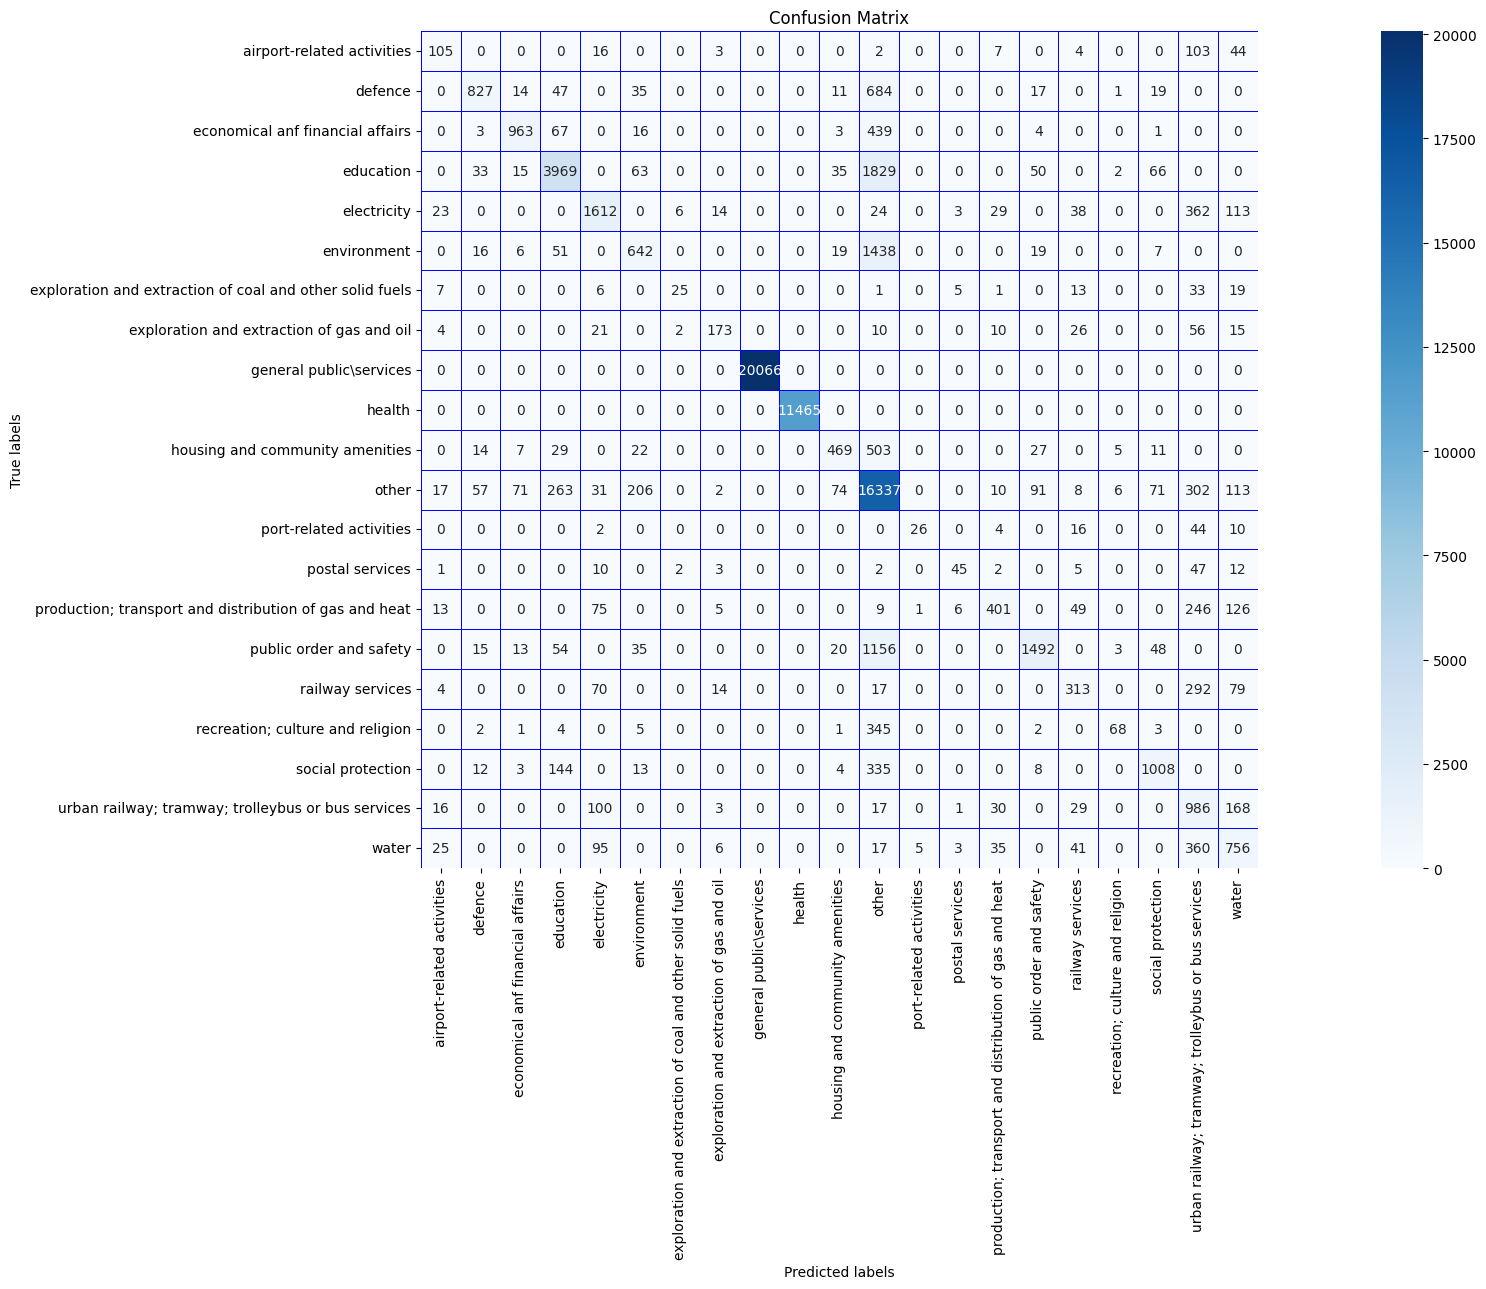

In [39]:
cnf_matrix_GB_GA = confusion_matrix(y_test_GA, y_pred_gb_GA)
generarGraficoMatrizConfusion(cnf_matrix_GB_GA, classes_GA)

In [40]:
metrics = calculate_class_metrics(cnf_matrix_GB_GA, classes_GA)
generarGraficoMetricas(classes_GA, metrics)

interactive(children=(Dropdown(description='Clase:', options=('airport-related activities', 'defence', 'econom…

In [41]:
visualizarImportanciaPredictores(gb_model_GA, "GRADIENT BOOSTING", "A")

Importancia de los predictores en el modelo GRADIENT BOOSTING - Experimento A
-------------------------------------------
                                predictor  importancia
9                             LOTS_NUMBER     0.297766
8                           NUMBER_AWARDS     0.196630
10                          NUMBER_OFFERS     0.156102
11                     NUMBER_TENDERS_SME     0.098003
4                            GROUP_CPV_15     0.054088
0                        B_MULTIPLE_CAE_n     0.034560
1                           B_ON_BEHALF_n     0.030421
5                      TYPE_OF_CONTRACT_w     0.026437
12                             CAE_TYPE_3     0.022795
7                     ISO_COUNTRY_CODE_si     0.020285
2                            GROUP_CPV_45     0.017686
13  MAIN_ACTIVITY_general public\services     0.014088
3                            GROUP_CPV_33     0.010126
6                    MAIN_ACTIVITY_health     0.009991
14                             CAE_TYPE_4     0.00987

### EXPERIMENTO B

In [112]:
X_combined_GB = np.vstack((X_train_GB[used_features], X_vali_GB[used_features]))
y_combined_GB = np.concatenate((y_train_GB,y_vali_GB))

In [113]:
test_fold_GB = np.full(X_combined_GB.shape[0], -1)  # Inicialmente, todas las muestras están en el conjunto de entrenamiento
test_fold_GB[len(X_train_GB[used_features]):(len(X_train_GB[used_features]) + len(X_vali_GB[used_features]))] = 0  # Las muestras del conjunto de prueba están en el conjunto de validación

In [114]:
ps_GB = PredefinedSplit(test_fold=test_fold_GB)

In [115]:
rejilla_GB = RandomizedSearchCV(estimator=random_forest_model, 
                      param_distributions=parametros_a_explorar, 
                      scoring='accuracy', 
                      n_jobs=-1,
                      cv=ps_GB)
rejilla_GB.fit(X_combined_GB, y_combined_GB)

c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=RandomForestClassifier(max_samples=0.6666666666666666,
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': ['sqrt', 'log2']},
                   scoring='accuracy')

In [116]:
print(f"El mejor accuracy es de {rejilla_GB.best_score_} lo tiene los HiperParametros {rejilla_GB.best_params_}")

El mejor accuracy es de 0.9899002173883691 lo tiene los HiperParametros {'max_features': 'sqrt', 'criterion': 'entropy'}


#### Entrenamiento

In [117]:
random_forest_model_GB = rejilla_GB.best_estimator_

In [118]:
gb_model_GB = GradientBoostingClassifier(
    learning_rate=0.1,          
    init=random_forest_model_GB        # Establecer el random_forest_model pre-entrenado como el estimador base
)

#### Random Forest

In [119]:
y_rf_pred_GB = random_forest_model_GB.predict(X_test_GB[used_features])

c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


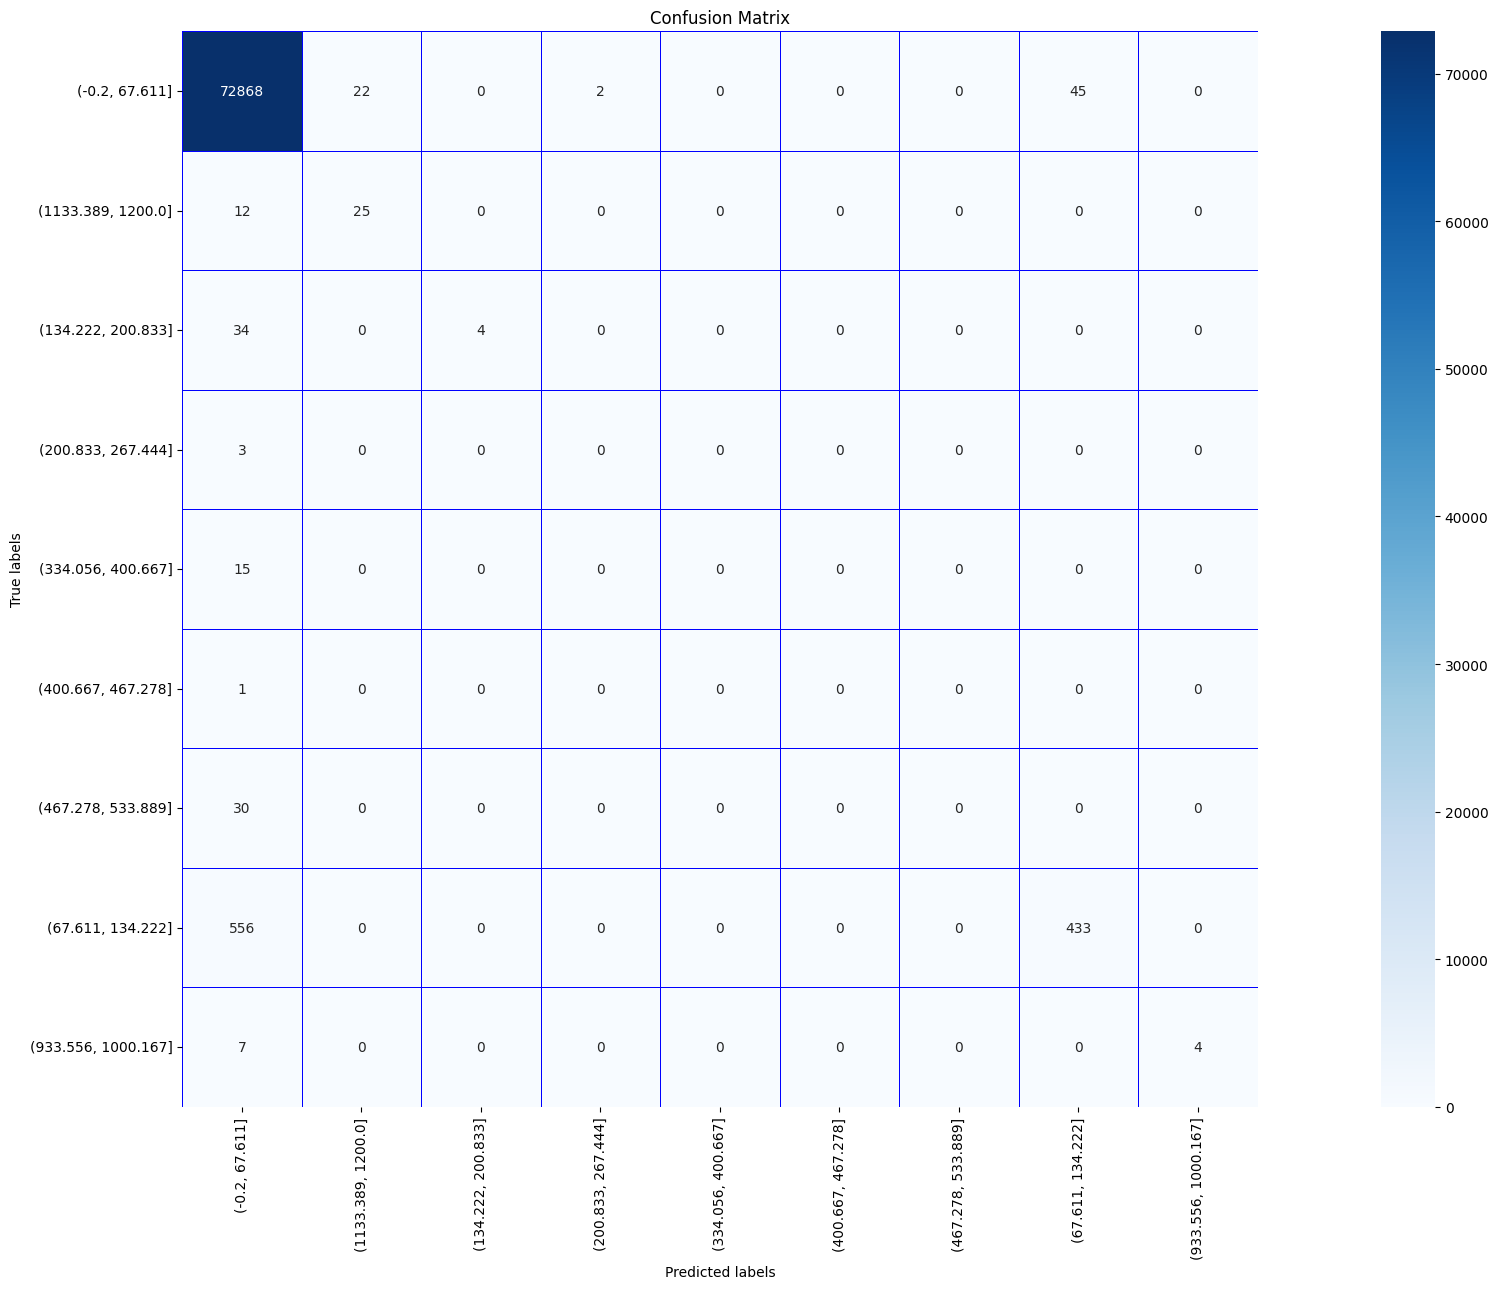

In [120]:
cnf_matrix_RF_GB=confusion_matrix(y_test_GB, y_rf_pred_GB)
generarGraficoMatrizConfusion(cnf_matrix_RF_GB, classes_GB)

In [121]:
metrics = calculate_class_metrics(cnf_matrix_RF_GB, classes_GB)
generarGraficoMetricas(classes_GB, metrics)

interactive(children=(Dropdown(description='Clase:', options=('(-0.2, 67.611]', '(1133.389, 1200.0]', '(134.22…

In [122]:
visualizarImportanciaPredictores(random_forest_model_GB, "RANDOM FOREST", "B")

Importancia de los predictores en el modelo RANDOM FOREST - Experimento B
-------------------------------------------
                                predictor  importancia
8                           NUMBER_AWARDS     0.223706
9                             LOTS_NUMBER     0.197382
10                          NUMBER_OFFERS     0.134636
11                     NUMBER_TENDERS_SME     0.113017
15                             CAE_TYPE_5     0.045162
13  MAIN_ACTIVITY_general public\services     0.043592
14                             CAE_TYPE_4     0.042516
1                           B_ON_BEHALF_n     0.038911
5                      TYPE_OF_CONTRACT_w     0.025973
6                    MAIN_ACTIVITY_health     0.024853
2                            GROUP_CPV_45     0.023748
3                            GROUP_CPV_33     0.023014
12                             CAE_TYPE_3     0.021146
0                        B_MULTIPLE_CAE_n     0.015455
16                    ISO_COUNTRY_CODE_lu     0.012956
4 

#### Gradient Boosting

In [123]:
random_search_EB_gb = RandomizedSearchCV(estimator=gb_model_GB, 
                                    param_distributions=parametros_a_explorar_GB,
                                    scoring='accuracy',
                                    n_jobs=-1, 
                                    random_state=42, 
                                    cv=ps)
random_search_EB_gb.fit(X_combined_GB, y_combined_GB)

c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=GradientBoostingClassifier(init=RandomForestClassifier(criterion='entropy',
                                                                                    max_samples=0.6666666666666666,
                                                                                    n_jobs=-1,
                                                                                    random_state=42)),
                   n_jobs=-1,
                   param_distributions={'max_features': ['sqrt', 'log2']},
                   random_state=42, scoring='accuracy')

In [124]:
print(f"El mejor accuracy es de {random_search_EB_gb.best_score_} lo tiene los HiperParametros {random_search_EB_gb.best_params_}")

El mejor accuracy es de 0.9899272221547103 lo tiene los HiperParametros {'max_features': 'sqrt'}


In [125]:
gb_model_GB = random_search_EB_gb.best_estimator_

In [126]:
y_pred_gb_GB = gb_model_GB.predict(X_test_GB[used_features])

c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


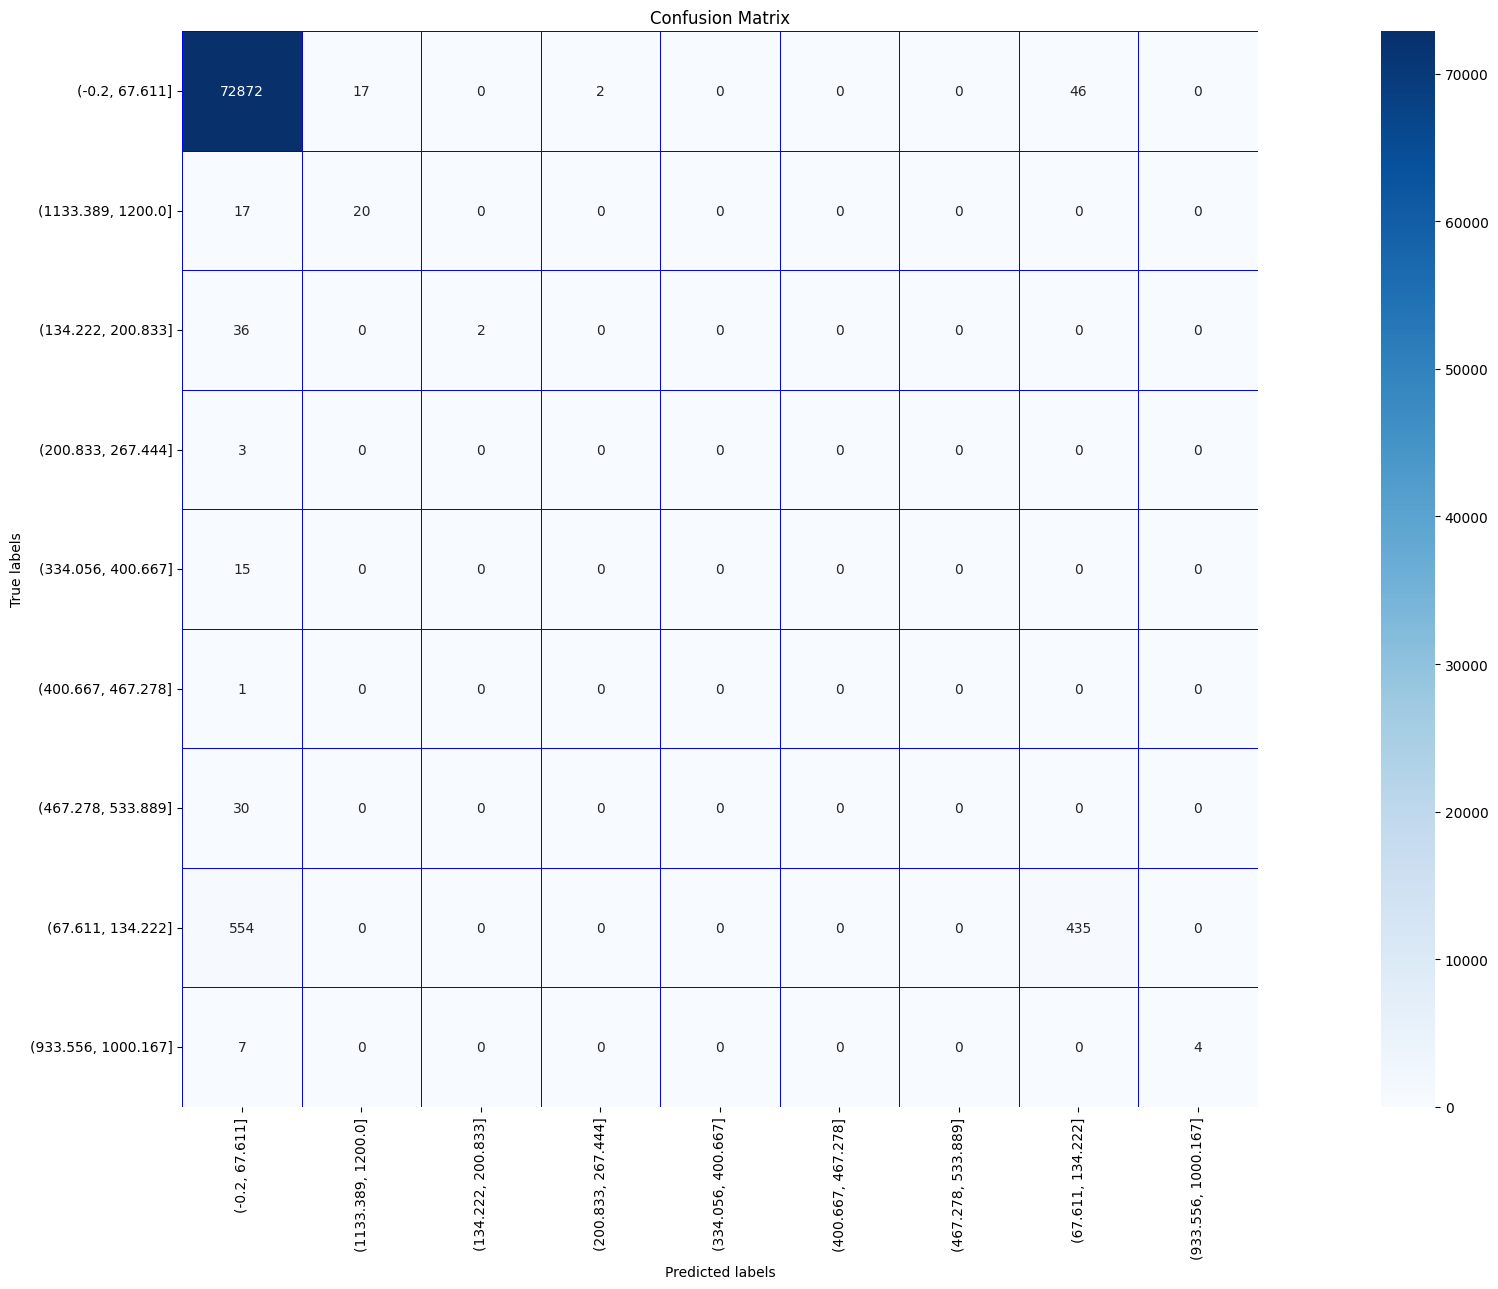

In [127]:
cnf_matrix_GB_GB = confusion_matrix(y_test_GB, y_pred_gb_GB)
generarGraficoMatrizConfusion(cnf_matrix_GB_GB, classes_GB)

In [128]:
metrics = calculate_class_metrics(cnf_matrix_GB_GB, classes_GB)
generarGraficoMetricas(classes_GB, metrics)

interactive(children=(Dropdown(description='Clase:', options=('(-0.2, 67.611]', '(1133.389, 1200.0]', '(134.22…

In [129]:
visualizarImportanciaPredictores(gb_model_GB, "GRADIENT BOOSTING", "B")

Importancia de los predictores en el modelo GRADIENT BOOSTING - Experimento B
-------------------------------------------
                                predictor  importancia
10                          NUMBER_OFFERS     0.303170
8                           NUMBER_AWARDS     0.187886
11                     NUMBER_TENDERS_SME     0.183215
9                             LOTS_NUMBER     0.171108
12                             CAE_TYPE_3     0.034233
13  MAIN_ACTIVITY_general public\services     0.025838
1                           B_ON_BEHALF_n     0.025427
6                    MAIN_ACTIVITY_health     0.018719
2                            GROUP_CPV_45     0.014978
0                        B_MULTIPLE_CAE_n     0.014779
3                            GROUP_CPV_33     0.008317
5                      TYPE_OF_CONTRACT_w     0.005637
7                     ISO_COUNTRY_CODE_si     0.002793
4                            GROUP_CPV_15     0.001695
14                             CAE_TYPE_4     0.00097

## Sistema de reglas

In [130]:
def convert_to_if_then(explanation, class_name, instance_to_explain):
    # Inicializa una lista para almacenar las partes de la regla
    rule_parts = []
    
    try:
        # Itera sobre las características y sus importancias
        for feature_name, importance in explanation.as_list(label=class_name):
            if importance > 0:
                # Agrega una parte de la regla para cada característica con importancia positiva
                rule_part = (f"{feature_name} tiene una importancia de {importance:.4f}")
                rule_parts.append(rule_part)
        
        # Combina todas las partes en una sola regla
        if rule_parts:
            combined_rule = (f"Con las condiciones actuales, se recomienda hacer una contratación en {instance_to_explain}. "
                             "Las siguientes características influyen: " +", ".join(rule_parts) + ".")
        else:
            combined_rule = (f"Con las condiciones actuales, se recomienda hacer una contratación en {instance_to_explain}. "
                             "No se encontraron características con importancia positiva.")
    except KeyError:
        combined_rule = (f"Con las condiciones actuales, se recomienda hacer una contratación en {instance_to_explain}. "
                         "No se encontraron explicaciones para esta clase.")
    
    return [combined_rule]

# RESPUESTAS A HIPOTESIS

## ¿Es posible que los modelos de predicción que incorporen técnicas de Machine Learning faciliten la disminución del tiempo de respuesta en la toma de decisiones en el sistema de recomendaciones públicas?

Sí, reduce mucho el tiempo de poder clasificar licitaciones haciendo que las beneficiarios directos como indirectos puedan dar uso al sistema y poder verificar junto a la XAI las deciciones.

## ¿Qué conclusiones se puede conseguir al comparar ambos modelos de ML en base a las métricas de precisión, accurancy, recall y F1 Score?

In [131]:
generarComparativaModelos(y_rf_pred_GA,y_pred_gb_GA,y_test_GA)

METRICAS               ACCURACY  PRECISION  RECALL  F1
Random Forest        -> 0.8337    0.7426   0.5420   0.5979
Gradient Boosting    -> 0.8337    0.7445   0.5420   0.5980


In [132]:
generarComparativaModelos(y_rf_pred_GB,y_pred_gb_GB,y_test_GB)

c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


METRICAS               ACCURACY  PRECISION  RECALL  F1
Random Forest        -> 0.9902    0.4921   0.2868   0.3227
Gradient Boosting    -> 0.9902    0.4929   0.2662   0.3067


# Predicciones

In [133]:
# "B_MULTIPLE_CAE_n"                             -> No hay  multiples autoridades contratantes
# "B_ON_BEHALF_n"                                -> No se realiza desde otra entidad

# "GROUP_CPV_45"                                 ->
# "GROUP_CPV_15"                                 ->
# "GROUP_CPV_33"                                 ->

# "TYPE_OF_CONTRACT_w"                           ->
# "MAIN_ACTIVITY_health"                         ->
# "ISO_COUNTRY_CODE_si"                          ->

#"NUMBER_AWARDS"                                 -> Números de contratos otorgados
#"LOTS_NUMBER"                                   -> Números de lotes que son llamados a licitación
#"NUMBER_OFFERS"                                 -> Número de licitacitantes
#"NUMBER_TENDERS_SME"                            -> Números de licitantes PYMES

#"CAE_TYPE_3"                                    -> Autoridad Regional or local authority
#"MAIN_ACTIVITY_general public\services"         -> actividad general public/services
#"CAE_TYPE_4"                                    -> Autoridad Water,energy, transport and telecommunications sector
#"CAE_TYPE_5"                                    -> autodrdad european Union institution/agency
#"ISO_COUNTRY_CODE_lu"                           -> País luxenburoug

In [134]:
data = np.array([[0,0,0,0,1,1,0,0,3,2,3,3,1,0,0,0,0], [1,1,0,1,0,1,1,0,2,3,1,1,0,1,1,0,1]])
df_to_predict = pd.DataFrame(data=data, columns=used_features)

## Experimento A

In [135]:
PREDICCION_RF_GA = random_forest_model_GA.predict(df_to_predict)
PREDICCION_GB_GA = gb_model_GA.predict(df_to_predict)

c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


### RANDOM FOREST

In [136]:
generarGraficosExplicativos(df_to_predict,classes_GA,random_forest_model_GA, PREDICCION_RF_GA)

Reglas para la clase 1:
  Con las condiciones actuales, se recomienda hacer una contratación en other. Las siguientes características influyen: MAIN_ACTIVITY_general public\services <= 0.25 tiene una importancia de 0.0209, MAIN_ACTIVITY_health <= 0.25 tiene una importancia de 0.0204, CAE_TYPE_4 <= 0.25 tiene una importancia de 0.0157, B_MULTIPLE_CAE_n <= 0.25 tiene una importancia de 0.0077, ISO_COUNTRY_CODE_lu <= 0.25 tiene una importancia de 0.0036, GROUP_CPV_15 > 0.75 tiene una importancia de 0.0034, NUMBER_TENDERS_SME > 2.50 tiene una importancia de 0.0023, NUMBER_OFFERS > 2.50 tiene una importancia de 0.0007.


ImportError: cannot import name 'display' from 'IPython.core.display' (C:\Users\dxcor\AppData\Roaming\Python\Python312\site-packages\IPython\core\display.py)

### GRADIENT BOOSTING

In [ ]:
generarGraficosExplicativos(df_to_predict,classes_GA,gb_model_GA, PREDICCION_GB_GA)

Reglas para la clase 1:
  Con las condiciones actuales, se recomienda hacer una contratación en other. Las siguientes características influyen: MAIN_ACTIVITY_health <= 0.25 tiene una importancia de 0.0223, MAIN_ACTIVITY_general public\services <= 0.25 tiene una importancia de 0.0208, CAE_TYPE_4 <= 0.25 tiene una importancia de 0.0154, ISO_COUNTRY_CODE_lu <= 0.25 tiene una importancia de 0.0064, B_MULTIPLE_CAE_n <= 0.25 tiene una importancia de 0.0062, NUMBER_TENDERS_SME > 2.50 tiene una importancia de 0.0032, NUMBER_OFFERS > 2.50 tiene una importancia de 0.0005.


ImportError: cannot import name 'display' from 'IPython.core.display' (C:\Users\dxcor\AppData\Roaming\Python\Python312\site-packages\IPython\core\display.py)

## Experimento B

In [137]:
PREDICCION_RF_GB = random_forest_model_GB.predict(df_to_predict)
PREDICCION_GB_GB = gb_model_GB.predict(df_to_predict)

c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


### RANDOM FOREST

In [139]:
generarGraficosExplicativos(df_to_predict,classes_GB,random_forest_model_GB, PREDICCION_RF_GB)

Reglas para la clase 1:
  Con las condiciones actuales, se recomienda hacer una contratación en (-0.2, 67.611]. No se encontraron características con importancia positiva.


ImportError: cannot import name 'display' from 'IPython.core.display' (C:\Users\dxcor\AppData\Roaming\Python\Python312\site-packages\IPython\core\display.py)

### GRADIENT BOOSTING

In [140]:
generarGraficosExplicativos(df_to_predict,classes_GB, gb_model_GB, PREDICCION_GB_GB)

Reglas para la clase 1:
  Con las condiciones actuales, se recomienda hacer una contratación en (-0.2, 67.611]. Las siguientes características influyen: MAIN_ACTIVITY_general public\services <= 0.25 tiene una importancia de 0.0000, NUMBER_OFFERS > 2.50 tiene una importancia de 0.0000, ISO_COUNTRY_CODE_lu <= 0.25 tiene una importancia de 0.0000.


ImportError: cannot import name 'display' from 'IPython.core.display' (C:\Users\dxcor\AppData\Roaming\Python\Python312\site-packages\IPython\core\display.py)

In [151]:
print("🔍 Columnas esperadas (len = {}):".format(len(used_features)))
print(used_features)


🔍 Columnas esperadas (len = 39):
['CAE_NAME', 'CAE_TOWN', 'CPV', 'CRIT_CRITERIA', 'CRIT_WEIGHTS', 'WIN_COUNTRY_CODE', 'B_CONTRACTOR_SME', 'DURATION', 'VALUE_EURO', 'CRIT_PRICE_WEIGHT', 'B_MULTIPLE_CAE_n', 'B_ON_BEHALF_n', 'GROUP_CPV_45', 'GROUP_CPV_33', 'GROUP_CPV_15', 'TYPE_OF_CONTRACT_w', 'MAIN_ACTIVITY_health', 'ISO_COUNTRY_CODE_si', 'NUMBER_AWARDS', 'LOTS_NUMBER', 'NUMBER_OFFERS', 'NUMBER_TENDERS_SME', 'CAE_TYPE_3', 'MAIN_ACTIVITY_general public\\services', 'CAE_TYPE_4', 'CAE_TYPE_5', 'ISO_COUNTRY_CODE_lu', 'GROUP_CPV', 'GROUP_VALUE_EURO', 'YEAR', 'CAE_TYPE', 'B_MULTIPLE_CAE', 'CAE_GPA_ANNEX', 'B_ON_BEHALF', 'ID_TYPE', 'ISO_COUNTRY_CODE', 'TOP_TYPE', 'TYPE_OF_CONTRACT', 'B_SUBCONTRACTED']


In [160]:
import numpy as np
import pandas as pd
import joblib

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, PredefinedSplit, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# ---------------------------------------------
# 1. Asumimos que df ya está cargado en memoria y limpio
# Variables seleccionadas como relevantes (usadas en Experimento B)
used_features: list[str] = [
    "B_MULTIPLE_CAE_n", "B_ON_BEHALF_n",
    "GROUP_CPV_45","GROUP_CPV_33","GROUP_CPV_15",
    "TYPE_OF_CONTRACT_w","MAIN_ACTIVITY_health", "ISO_COUNTRY_CODE_si",
    "NUMBER_AWARDS", "LOTS_NUMBER", 
    "NUMBER_OFFERS", "NUMBER_TENDERS_SME",
    "CAE_TYPE_3", "MAIN_ACTIVITY_general public\\services",
    "CAE_TYPE_4", "CAE_TYPE_5", "ISO_COUNTRY_CODE_lu"
]

X = df[used_features]
y = df["GROUP_DURATION"]  # Objetivo de Experimento B

# ---------------------------------------------
# 2. División de datos (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_vali, X_test, y_vali, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Combinados para validación cruzada fija
test_fold = np.full(len(X_train) + len(X_vali), -1)
test_fold[len(X_train):] = 0
ps = PredefinedSplit(test_fold)
X_combined = pd.concat([X_train, X_vali])
y_combined = np.concatenate([y_train, y_vali])

# ---------------------------------------------
# 3. Preprocesador
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X.select_dtypes(include=["number"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ("num", StandardScaler(), num_features)
])

# ---------------------------------------------
# 4. Random Forest pipeline
rf_model = RandomForestClassifier(
    bootstrap=True,
    n_jobs=-1,
    max_samples=2/3,
    random_state=42,
    n_estimators=100,
    warm_start=False
)

param_rf = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_features": ["sqrt", "log2"]
}

rf_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", rf_model)
])

rf_search = RandomizedSearchCV(estimator=rf_pipeline,
                                param_distributions=param_rf,
                                scoring="accuracy",
                                cv=ps,
                                n_jobs=-1)
rf_search.fit(X_combined, y_combined)
rf_best = rf_search.best_estimator_
rf_best.used_features = used_features

# ---------------------------------------------
# 5. Gradient Boosting pipeline
gb_model = GradientBoostingClassifier(random_state=42)

param_gb = {
    "classifier__max_features": ["sqrt", "log2"]
}

gb_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", gb_model)
])

gb_search = RandomizedSearchCV(estimator=gb_pipeline,
                                param_distributions=param_gb,
                                scoring="accuracy",
                                cv=ps,
                                n_jobs=-1)
gb_search.fit(X_combined, y_combined)
gb_best = gb_search.best_estimator_
gb_best.used_features = used_features

# ---------------------------------------------
# 6. Guardar archivo .pkl
modelos = {
    "random_forest": rf_best,
    "gradient_boosting": gb_best
}

joblib.dump(modelos, "modelos_experimento_B.pkl")

print("✅ Archivo 'modelos_experimento_B.pkl' creado con éxito.")


c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\dxcor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✅ Archivo 'modelos_experimento_B.pkl' creado con éxito.
